<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.5.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [3]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [4]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [5]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [6]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [7]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [9]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [10]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [11]:
word2idx

{'second-round': 1,
 'Mientes': 2,
 'Razumkov': 3,
 'Sami': 4,
 'Six-nation': 5,
 'Diabetes': 6,
 'basing': 7,
 'Ambuhl': 8,
 'Image': 9,
 'nevertheless': 10,
 'Chilean': 11,
 'cover-up': 12,
 'Chitchai': 13,
 'Ahadi': 14,
 're-establish': 15,
 'Astronauts': 16,
 'Ivanic': 17,
 'boycott': 18,
 'Lourdes': 19,
 'CNN-Turk': 20,
 'wished': 21,
 'trooper': 22,
 'mid-2008': 23,
 'Abderrahaman': 24,
 'primacy': 25,
 'meet': 26,
 'Bouarfa': 27,
 'Zwelinzima': 28,
 'handover': 29,
 'Shui-bian': 30,
 'depleting': 31,
 'undocked': 32,
 '227': 33,
 'Sardenberg': 34,
 'one-quarter': 35,
 '10,00,000': 36,
 'Viceroyalty': 37,
 'safety': 38,
 'mentions': 39,
 'Enzo': 40,
 'Rafiqi': 41,
 'Ecweru': 42,
 'withdrawing': 43,
 'gymnast': 44,
 'Pace': 45,
 '58th': 46,
 'destitute': 47,
 'bin': 48,
 'groom': 49,
 'Bankruptcy': 50,
 'Aviation': 51,
 'Number': 52,
 'Thamilselvan': 53,
 'pneumonic': 54,
 'lip': 55,
 'volt': 56,
 'hatched': 57,
 'screens': 58,
 'frame': 59,
 'Vasconcelos': 60,
 'cross-straits': 6

In [12]:
tag2idx

{'I-org': 0,
 'I-art': 1,
 'O': 2,
 'B-geo': 3,
 'I-tim': 4,
 'B-org': 5,
 'B-eve': 6,
 'I-nat': 7,
 'I-per': 8,
 'B-art': 9,
 'B-tim': 10,
 'I-geo': 11,
 'I-eve': 12,
 'B-per': 13,
 'I-gpe': 14,
 'B-nat': 15,
 'B-gpe': 16}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

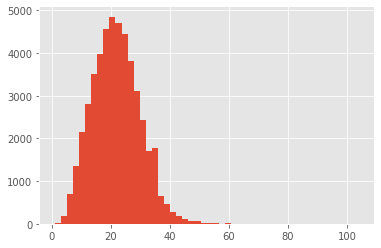

In [13]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [14]:
print(num_words)

35179


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [16]:
print(sentences[0])
print(X[0], X[0].shape)
print(y[0], y[0].shape)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]
[10296  1040 29571 29972 18983 10170 24883  5819  7928 15867 11749 30893
 10012 24510  9377 15867 31105  1040 27970 17354 17412 20219 18476 32752
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178] (50,)
[ 2  2  2  2  2  2  3  2  2  2  2  2  3  2  2  2  2  2 16  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(38367, 50) (38367, 50)
(9592, 50) (9592, 50)


### Task 6: Build and Compile a Bidirectional LSTM Model

In [18]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [19]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Task 7: Train the Model

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

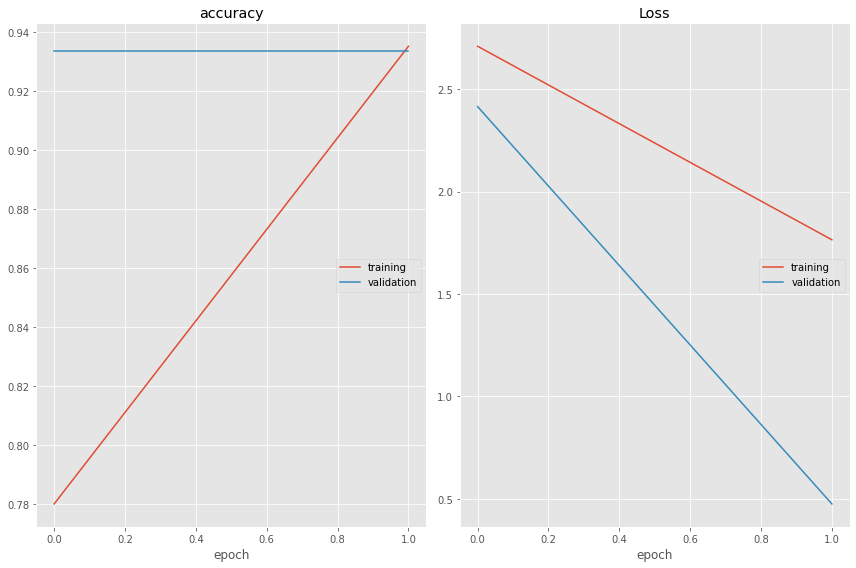

accuracy
	training         	 (min:    0.780, max:    0.935, cur:    0.935)
	validation       	 (min:    0.934, max:    0.934, cur:    0.934)
Loss
	training         	 (min:    1.765, max:    2.710, cur:    1.765)
	validation       	 (min:    0.475, max:    2.415, cur:    0.475)

Epoch 00002: val_loss improved from 2.41540 to 0.47519, saving model to model_weights.h5
CPU times: user 50 s, sys: 2.91 s, total: 52.9 s
Wall time: 44.8 s


In [22]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train[0:200],
    y=y_train[0:200],
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

### Task 8: Evaluate Named Entity Recognition Model

In [23]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 16s 54ms/step - loss: 0.4752 - accuracy: 0.9337


[0.4751904010772705, 0.9336843490600586]

In [24]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            O	O
United         B-org	O
Nations        I-org	O
has            O	O
been           O	O
under          O	O
fire           O	O
for            O	O
failing        O	O
to             O	O
stop           O	O
ongoing        O	O
ethnic         O	O
violence       O	O
in             O	O
Ituri          B-geo	O
.              O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	O
Report         O	